<a href="https://colab.research.google.com/github/Diego-CB/DS-Proyecto/blob/main/modelo/Autogluon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo
### Predicción de argumentos efectivos
    
Grupo:
- Cristian Aguirre: 20231
- Diego Córdova: 20212
- Marco Jurado: 20308
- Paola Contreras: 20213
- Paola de León: 20361

In [47]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

## Carga de Datos de Entreno

In [48]:
id = '1kzPayZj888s0RkHlxYHGXzHwdb63fEYH'
url = 'https://drive.google.com/uc?id=' + id
data = pd.read_csv(url)
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


## Liempieza de dataset de entreno

Se eliminaran las columnas de ***discourse_id*** y ***essay_id*** debido a que estas son solo identificadores no relevantes para el modelo. AL contrario, podrian causar ruido que genere malas predicciones.

Ademas se agrega una columna ***index*** y se guarda la columna ***discourse_text*** en una variable aparte ya que esta servira como entrada de la capa de word embedding.

Vamos a normalizar los datos para no generar ningun tipo de tendencia en el modelo pues como se ha visto en el analisis de datos los datos no estan nivelados y tenemos muchos más registros de un tipo de que de otro.

In [49]:
min_count = data['discourse_effectiveness'].value_counts().min()

# Filtrar las categorías 'adequate' y 'effective' para igualar el tamaño de 'ineffective'.
adequate_data = data[data['discourse_effectiveness'] == 'Adequate']
effective_data = data[data['discourse_effectiveness'] == 'Effective']

# Si hay más elementos que la cantidad mínima, eliminar los extras
if len(adequate_data) > min_count:
    adequate_data = adequate_data.sample(min_count, replace=False)

if len(effective_data) > min_count:
    effective_data = effective_data.sample(min_count, replace=False)

# Concatenar los DataFrames filtrados
data = pd.concat([adequate_data, effective_data, data[data['discourse_effectiveness'] == 'Ineffective']])

data.reset_index(drop=True, inplace=True)


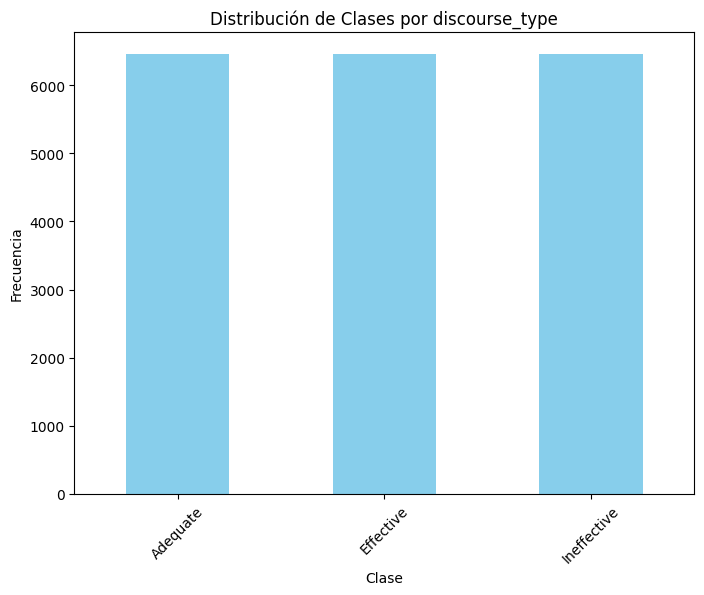

In [50]:
class_counts = data['discourse_effectiveness'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [51]:
data.drop('discourse_id', axis=1, inplace=True)
data.drop('essay_id', axis=1, inplace=True)
data.head()

,discourse_text,discourse_type,discourse_effectiveness
0,"So, Instead of thinking about how to make sure...",Evidence,Adequate
1,We cattle boat sailers don't give up we are re...,Evidence,Adequate
2,"please mister senator,please make the right ch...",Concluding Statement,Adequate
3,"Some single parents don't have time to work, d...",Evidence,Adequate
4,without after school activities students would...,Claim,Adequate


Se agregara una variable para obtener el tamaño en palabras del texto como input

In [52]:
claim_sizes = [len(text) for text in data['discourse_text']]
data['claim_size'] = claim_sizes
data.head()

,discourse_text,discourse_type,discourse_effectiveness,claim_size
0,"So, Instead of thinking about how to make sure...",Evidence,Adequate,335
1,We cattle boat sailers don't give up we are re...,Evidence,Adequate,672
2,"please mister senator,please make the right ch...",Concluding Statement,Adequate,434
3,"Some single parents don't have time to work, d...",Evidence,Adequate,282
4,without after school activities students would...,Claim,Adequate,78


In [53]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
y = data['discourse_effectiveness']
X = data.drop('discourse_effectiveness', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
X_train['discourse_effectiveness'] = y_train

In [55]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
!pip install autogluon --no-cache-dir
!pip install autogluon autogluon.tabular

  Using cached setuptools-68.2.2-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
openxlab 0.0.28 requires setuptools~=60.2.0, but you have setuptools 68.2.2 which is incompatible.
tensorflow 2.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.2.2
    Uninstalling setuptools-68.2.2:
      Successfully uninstalled setuptools-68.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 60.2.0 which is incompatible.
tensorflow 2.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
torchaudio 2.1.0+cu118 requires

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
predictor = TabularPredictor(
    label="discourse_effectiveness",
    problem_type='multiclass',
    eval_metric='accuracy'
).fit(train_data=X_train, time_limit=200, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_011052/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 200s
AutoGluon will save models to "AutogluonModels/ag-20231108_011052/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   50.07 GB / 83.96 GB (59.6%)
Train Data Rows:    19386
Train Data Columns: 3
Label Column: discourse_effectiveness
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12000.16 MB
	Train Data (Original)  Memory Usage: 6.27 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

                    model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetFastAI_BAG_L1   0.543021       1.224241  84.215541                1.224241          84.215541            1       True          1
1     WeightedEnsemble_L2   0.543021       1.226668  84.227739                0.002427           0.012198            2       True          2


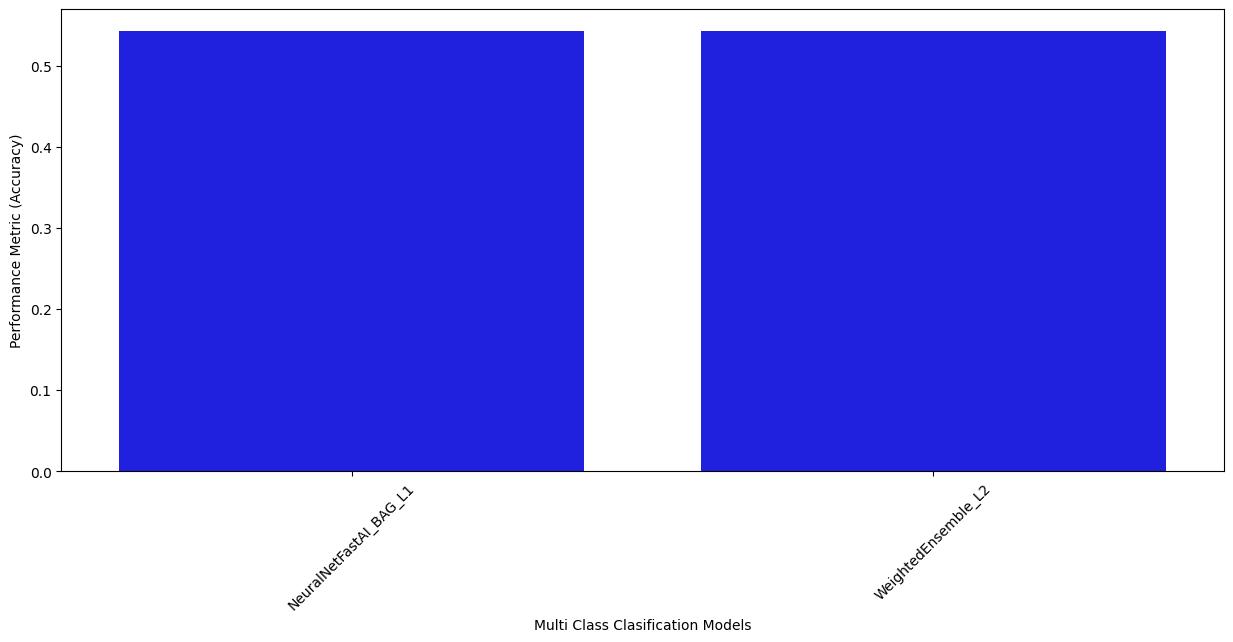

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = "model", y = "score_val", data = predictor.leaderboard(), color = "b")
ax.set(ylabel = "Performance Metric (Accuracy)", xlabel = "Multi Class Clasification Models")
plt.xticks(rotation = 45);

In [57]:
from autogluon.multimodal import MultiModalPredictor
import uuid

time_limit = 3 * 60  # set to larger value in your applications
model_path = f"./tmp/-{uuid.uuid4().hex}-automm_text_book_price_prediction"
predictor = MultiModalPredictor(
    path=model_path,
    label="discourse_effectiveness",
    problem_type='multiclass',
)
predictor.fit(X_train, time_limit=time_limit)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction".

- Validation metric is "accuracy".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

1 GPUs are detected, and 1 GPUs will be used.
   - GPU 0 name: Tesla T4
   - GPU 0 memory: 15.57GB/15.84GB (Free/Total)
CUDA version is 11.7.

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 54: 'val_accuracy' reached 0.57769 (best 0.57769), saving model to '/content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction/epoch=0-step=54.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 86: 'val_accuracy' reached 0.55835 (best 0.57769), saving model to '/content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction/epoch=0-step=86.ckpt' as top 3
Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/-46518f62036f424e9729eb4f644b71c7-automm_text_book_price_prediction
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




## Tunning

In [ ]:
# TODO
# https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html

Predicting: 0it [00:00, ?it/s]

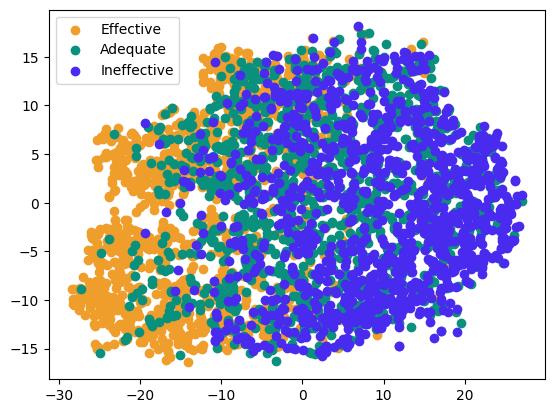

In [75]:
from sklearn.manifold import TSNE
X_val = X_test.copy()
X_val['discourse_effectiveness'] = y_test
embeddings = predictor.extract_embedding(X_val)
X_embedded = TSNE(n_components=3, random_state=123).fit_transform(embeddings)
for val, color in [('Effective', '#f09e2b'), ('Adequate', '#0a917d'), ('Ineffective', '#492bf0')]:
    idx = (X_val['discourse_effectiveness'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'{val}')
plt.legend(loc='best')

## Cargar modelo

In [77]:
import os
from autogluon.multimodal import MultiModalPredictor
import uuid

# Ruta nueva con el nombre del predictor
ruta_nueva = "./tmp/Predictor"

# Renombrar la carpeta
os.rename(model_path, ruta_nueva)
predictor_loaded = MultiModalPredictor.load('tmp/Predictor')

Load pretrained checkpoint: /content/tmp/predictor/model.ckpt


## Evaluacion de Modelo

In [81]:
from sklearn.metrics import classification_report
y_pred = predictor_loaded.predict(X_test)

# Calcular el informe de clasificación
report = classification_report(y_test, y_pred)

# Imprimir el informe
print("Informe de Clasificación:")
print(report)

Predicting: 0it [00:00, ?it/s]

Informe de Clasificación:
              precision    recall  f1-score   support

    Adequate       0.47      0.33      0.39      1286
   Effective       0.60      0.89      0.72      1310
 Ineffective       0.66      0.53      0.59      1282

    accuracy                           0.59      3878
   macro avg       0.58      0.58      0.57      3878
weighted avg       0.58      0.59      0.57      3878



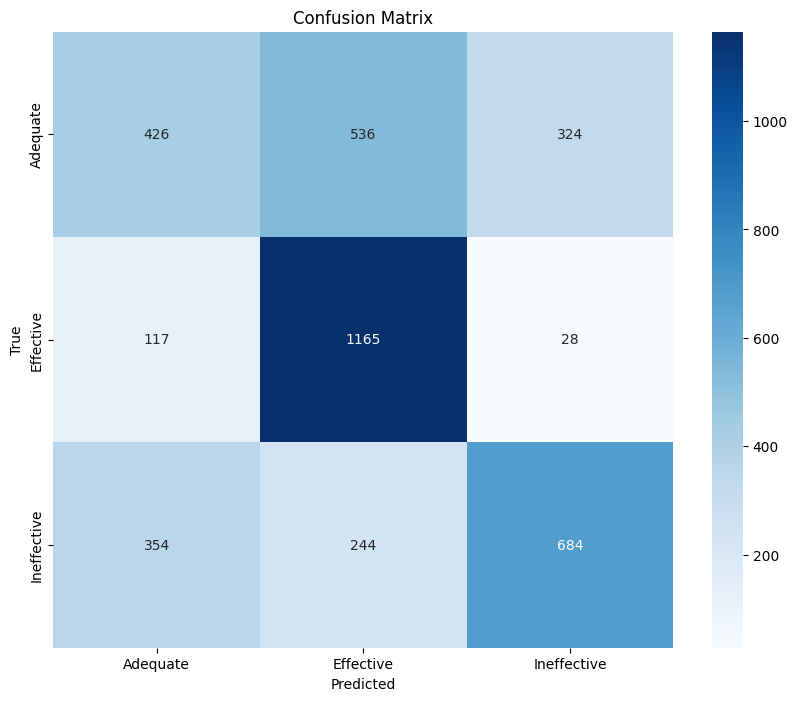

In [80]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Convertir la matriz de confusión a un DataFrame de pandas para una mejor visualización
conf_matrix_df = pd.DataFrame(conf_matrix, columns=predictor_loaded.class_labels, index=predictor_loaded.class_labels)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=predictor_loaded.class_labels, yticklabels=predictor_loaded.class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Ejemplo de prediccion

In [82]:
probs = predictor.predict_proba(X_test.loc[0])
probs

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/autogluon/multimodal/predictor.py:2321 in predict_proba  │
│                                                                                                  │
│   2318 │   │   │   │   return_prob=True,                                                         │
│   2319 │   │   │   )                                                                             │
│   2320 │   │   else:                                                                             │
│ ❱ 2321 │   │   │   outputs = predict(                                                            │
│   2322 │   │   │   │   predictor=self,                                                           │
│   2323 │   │   │   │   data=data,                                                                │
│   2324 │   │   │   │   requires_label=False,                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/autogluon/multimodal/utils/inference.py:499 in predict   │
│                                                                                                  │
│   496 │   │   │   signature=signature,                                                           │
│   497 │   │   )                                                                                  │
│   498 │   else:                                                                                  │
│ ❱ 499 │   │   data, df_preprocessor, data_processors = predictor._on_predict_start(              │
│   500 │   │   │   data=data,                                                                     │
│   501 │   │   │   requires_label=requires_label,                                                 │
│   502 │   │   )                                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/autogluon/multimodal/predictor.py:1850 in                │
│ _on_predict_start                                                                                │
│                                                                                                  │
│   1847 │   │   │   column_names = list(self._column_types.keys())                                │
│   1848 │   │   │   # remove label column since it's not required in inference.                   │
│   1849 │   │   │   column_names.remove(self._label_column)                                       │
│ ❱ 1850 │   │   │   data = data_to_df(                                                            │
│   1851 │   │   │   │   data=data,                                                                │
│   1852 │   │   │   │   required_columns=self._df_preprocessor.required_feature_names,            │
│   1853 │   │   │   │   all_columns=column_names,                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/autogluon/multimodal/utils/data.py:491 in data_to_df     │
│                                                                                                  │
│   488 │   │   else:                                                                              │
│   489 │   │   │   data = load_pd.load(data)                                                      │
│   490 │   else:                                                                                  │
│ ❱ 491 │   │   raise NotImplementedError(                   